##### Machine Learning LAB 1: MODEL SELECTION

Course 2025/26: *F. Chiariotti*

The notebook contains a simple learning task over which we will implement **MODEL SELECTION AND VALIDATION**.

Complete all the **required code sections** and **answer all the questions**.

### IMPORTANT for the exam:

The functions you might be required to implement in the exam will have the same signature and parameters as the ones in the labs

## Polynomial Classification on Signal to Noise Ratios

In this notebook we are going to explore the use of polynomial classification with polynomial regression. We are going to use the Numpy **polyfit** function, which performs polynomial regression.

Our use case is a communication problem: we have a set of measurements of the Signal to Noise Ratio (SNR), i.e., the quality of the communication link, in various positions. The SNR depends on two components: firstly, the noise level (which is a random variable that does not depend on position) and the signal attenuation (usually modeled as a polynomial function of the distance).

Our transmitter is in (0,0), and coordinates are in meters. In urban scenarios, the attenuation usually follows a third-degree polynomial, but it might be a fourth- or fifth-degree polynomial in more complex cases. How do we choose between different degrees? We will try with a maximum of **6**

---

## Import all the necessary Python libraries

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import itertools
import random
from matplotlib import pyplot as plt

seed = 122

---

## Load the data

In this case, x and y are the two coordinates, and the SNR is the thing we are trying to predict

**DO NOT CHANGE THE PRE-WRITTEN CODE UNLESS OTHERWISE SPECIFIED**

In [2]:
df = pd.read_csv('data/snr_measurements.csv',sep=';')
x = df['x'].to_numpy()
y = df['y'].to_numpy()
SNR = df['SNR'].to_numpy()

## Helper functions

These functions will help us evaluate the results

In [3]:
def compute_distance(x, y):
    # TODO: Compute the Euclidean distance from the origin
    distance = np.sqrt(x**2 + y**2)
    return distance

def fit(distance, SNR, degree):
    return np.polyfit(distance, SNR, deg=degree)

def predict(distance, poly_coeffs):
    SNR = 0
    deg = poly_coeffs.shape[0]
    coeffs = poly_coeffs[::-1]  # inverti l’ordine dei coefficienti (restituiti dal grado maggiore)
    for i in range(deg):
        SNR += coeffs[i] * distance**i
    return SNR

def evaluate(distance, SNR, poly_coeffs):
    mse = (((predict(distance, poly_coeffs) - SNR))**2).mean()
    return mse

def separate_test(distance, SNR, test_points):
    # TODO: Return a training set and a test set (the test_points parameter controls the number of test points).
    # The points should be selected randomly
    idx = list(range(len(x)))
    test_idx = random.sample(idx, test_points)
    train_idx = [i for i in idx if i not in test_idx]


    x_train, y_train, x_test, y_test = np.array(distance[train_idx]), np.array(SNR[train_idx]), np.array(distance[test_idx]), np.array(SNR[test_idx])

    return x_train, y_train, x_test, y_test

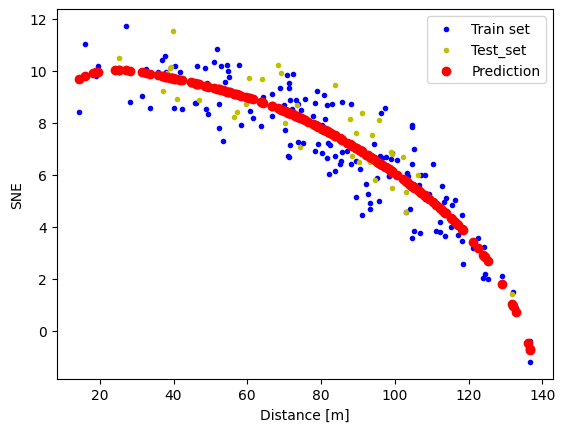

In [4]:
# TODO: separate the training and test sets and create a scatter plot of the SNR as a function of the distance
distance = compute_distance(x, y)
poly_coeffs = fit(distance, SNR, 6)
SNR_pred = predict(distance, poly_coeffs)
mse = evaluate(distance, SNR, poly_coeffs)
#separate
test_points = 40
sets = separate_test(distance, SNR, test_points)

plt.scatter(sets[0], sets[1], marker='.', color='b', label='Train set')
plt.scatter(sets[2], sets[3], marker='.', color='y', label='Test_set')
plt.scatter(distance, SNR_pred, marker='o', color='r', label='Prediction')
plt.xlabel('Distance [m]')
plt.ylabel('SNE')
plt.legend()
plt.tight_layout
plt.show()

## A. K-fold cross-validation

In this case, x and y are the two coordinates, and the SNR is the thing we are trying to predict
It's a SELECTION tecnique, based on validation set. We will select the best polinomial in the class.

In [28]:
# Function to perform the K-fold cross validation
def k_fold_cross_validation(x_train: np.ndarray, y_train: np.ndarray, k: int, max_degree: int) -> tuple[tuple, tuple]:
    random.seed(seed)
    np.random.seed(seed)
    # TODO: Perform K-fold cross-validation on the training set.
    # The two returned values are the best model and the list of results for all degrees up to max_degree.
    # The points should be selected randomly.
    # The inputs and labels are already in terms of distance and SNR

    best_perf = 1e20 #initial

    N = len(x_train)
    indices = np.random.permutation(N)
    idx_folds = np.array_split(indices, k)

    mean_mse_k = np.zeros(max_degree + 1)
    
    for deg in range(0, max_degree + 1):
        mse_k = 0
        for idx_val in idx_folds:
            idx_train = [i for i in indices if i not in idx_val]
            poly_coeffs = fit(x_train[idx_train], y_train[idx_train], deg)
            mse_k += evaluate(x_train[idx_val], y_train[idx_val], poly_coeffs)
        mean_mse_k[deg] = mse_k / k
    
        if (best_perf > mean_mse_k[deg]):
            best = fit(x_train, y_train, deg) #best degree coeffs evaluated over ALL Train, with best degree 
            best_perf = mean_mse_k[deg] #upgrade
            best_deg = deg
         
    results = mean_mse_k
    return best, results, best_deg

mse(deg): 
 [5.8289283  1.5795721  0.98047497 0.96669575 0.95310593 1.00549088
 0.9958477 ]
Best model coeffs: 
 [-1.45897228e-07  3.87472068e-05 -4.16458815e-03  1.54324218e-01
  8.20662618e+00]
Best degree: 4


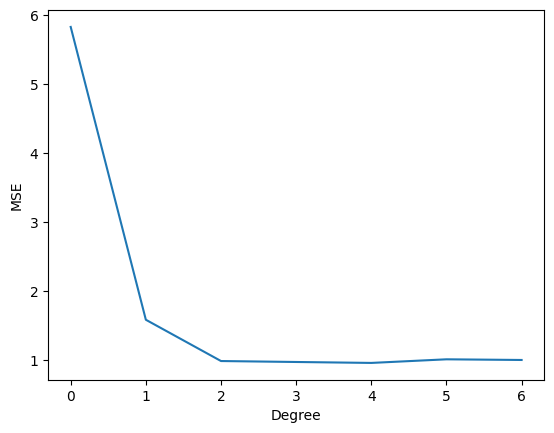

In [34]:
# TODO: run the training with K-fold cross-validation with 40 test points and 4 folds Plot the validation score as a function of the degree

K = 4
max_degree = 6
test_points = 40

distance = compute_distance(x, y)
x_train, y_train, x_test, y_test = separate_test(distance, SNR, test_points)
best_model, results, best_deg = k_fold_cross_validation(x_train, y_train, K, max_degree)
print("mse(deg): \n", results)
print("Best model coeffs: \n", best_model)
print("Best degree:", best_deg)
plt.plot(range(0, max_degree + 1), results)
plt.xlabel('Degree')
plt.ylabel('MSE')
plt.show()

results_K, best_model_K = results, best_model

[-1.11330730e-07  3.10410639e-05 -3.72559073e-03  1.55084827e-01
  7.91310913e+00] 1.0148764446832934


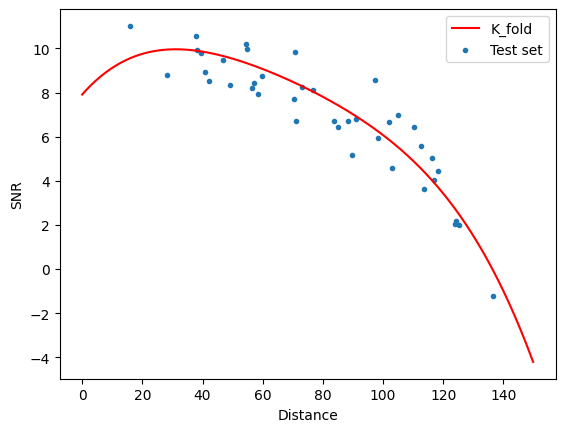

In [7]:
#test the prediction
dist_vals = np.arange(0,150,0.1)
pred_SNR = np.zeros(1500)
for i in range(1500):
    pred_SNR[i] = predict(dist_vals[i], best_model)

print(best_model, evaluate(x_test, y_test, best_model))

plt.plot(dist_vals, pred_SNR, color='r', label='K_fold')
plt.scatter(x_test, y_test, marker='.', label='Test set')
plt.xlabel('Distance')
plt.ylabel('SNR')
plt.legend()
plt.show()

In [8]:
# TODO: get the test performance of the best model and plot the model output and test points. 
# Try running the program multiple times, changing the values of K and the number of test points: is the output always the same?

---

## B. Tikhonov regularization

Change the loss function to include a Tikhonov regularization term, as an alternative to cross-validation (try $\lambda=0.01$)

In [23]:
def evaluate_tikhonov(x_train: np.ndarray, y_train: np.ndarray, lambda_par: float, max_degree: int) -> tuple[tuple, tuple]:
    # TODO: apply Tikhonov regularization AFTER the fitting process
    results = []
    best = -1 #generic type
    best_loss = 1e10
    best_deg = 0

    for deg in range(0, max_degree + 1):
        poly_coeffs = fit(x_train, y_train, deg)
        mse = evaluate(x_train, y_train, poly_coeffs)
        reg_term = np.linalg.norm(poly_coeffs)**2 
        loss = mse + lambda_par * reg_term
        results.append(float(loss))

        if (best_loss > loss):
            best_loss = loss 
            best = poly_coeffs
            best_deg = deg
            
    return best, results, best_deg

loss(deg): 
 [6.166514125063965, 3.152465098424862, 1.7853309526047303, 2.1000686033315974, 1.5297976678103862, 1.7280934677678137, 1.3617763262491052]
Best model coeffs: 
 [-3.89895563e-11  1.65371465e-08 -2.88900030e-06  2.63925328e-04
 -1.36343326e-02  3.41876637e-01  6.88347566e+00]
Best degree: 6


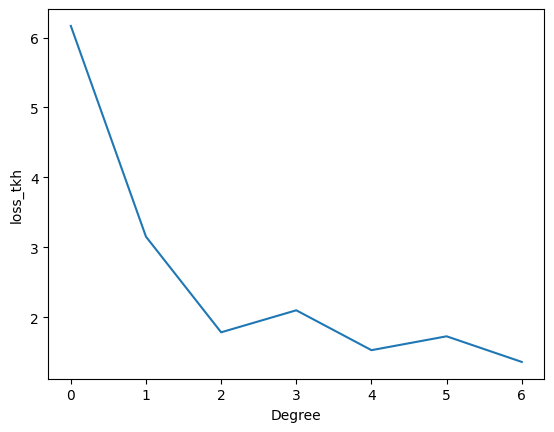

In [24]:
# TODO: run the training with Tikhonov regularization and plot the loss as a function of the degree

max_degree = 6
# test_points = 40 not neede, has been separated in the previous point
lambda_par = 0.01

best_model_tkh, results, best_deg = evaluate_tikhonov(x_train, y_train, lambda_par, max_degree)
print("loss(deg): \n", results)
print("Best model coeffs: \n", best_model_tkh)
print("Best degree:", best_deg)
plt.plot(range(0, max_degree + 1), results)
plt.xlabel('Degree')
plt.ylabel('loss_tkh')
plt.show()

results_tkh = results

In [11]:
# best deg = 6 -> but higher coeffs is 10^-11 -> neglectable
# plot off loss_tkh at the end in comparison

## C. Minimum description length regularization

Change the loss function to include a representation length regularization term, as an alternative to cross-validation. The minimum description length of a polynomial of degree N is O(2^N) - try $\lambda=0.02$

In [18]:
def evaluate_representation(x_train: np.ndarray, y_train: np.ndarray, lambda_par: float, max_degree: int) -> tuple[tuple, tuple]:
    # TODO: apply Tikhonov regularization AFTER the fitting process
    # In this case we want to penalize "np.power(2, deg + 1) * lambda_par" = lr * (d+1) which is the bit lenght of the hypothesis

    results = []
    best = -1 #generic type
    best_loss = 1e10
    best_deg = 0

    for deg in range(0, max_degree + 1):
        poly_coeffs = fit(x_train, y_train, deg)
        mse = evaluate(x_train, y_train, poly_coeffs)
        reg_term = (deg + 1)**2 # Always remember that we are trating squares 
        loss = mse + lambda_par * reg_term
        results.append(float(loss))

        if (best_loss > loss):
            best_loss = loss 
            best = poly_coeffs
            best_deg = deg
    return best, results, best_deg

loss(deg): 
 [5.642333260331253, 1.5390325822788167, 1.0446584649664752, 1.0795994012698111, 1.1393768567046076, 1.248088154917388, 1.3767832986398907]
Best model coeffs: 
 [-3.89895563e-11  1.65371465e-08 -2.88900030e-06  2.63925328e-04
 -1.36343326e-02  3.41876637e-01  6.88347566e+00]
Best degree: 2


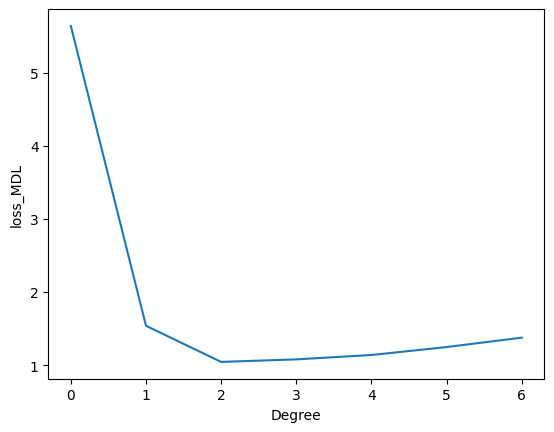

In [25]:
# TODO: run the training with MDL regularization and plot the loss as a function of the degree

max_degree = 6
lambda_par = 0.01

best_model_MDL, results, best_deg = evaluate_representation(x_train, y_train, lambda_par, max_degree)
print("loss(deg): \n", results)
print("Best model coeffs: \n", best_model_tkh)
print("Best degree:", best_deg)
plt.plot(range(0, max_degree + 1), results)
plt.xlabel('Degree')
plt.ylabel('loss_MDL')
plt.show()

results_MDL = results

### TEST

Check the performance of the three solutions on the test set: which one does best?


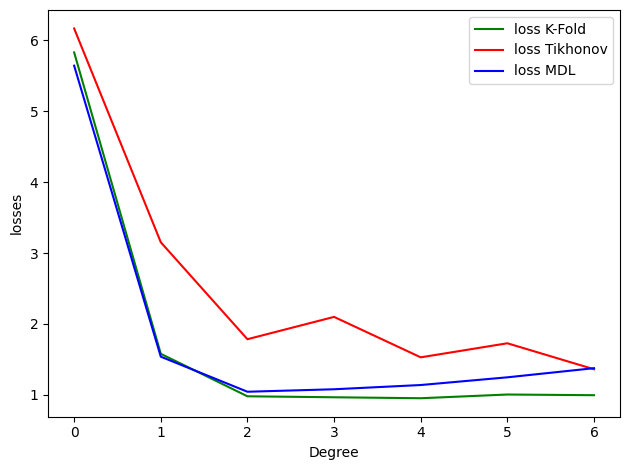

In [33]:
plt.plot(range(0, max_degree + 1), results_K, color='g', label='loss K-Fold')
plt.plot(range(0, max_degree + 1), results_tkh, color='r', label='loss Tikhonov')
plt.plot(range(0, max_degree + 1), results_MDL, color='b', label='loss MDL')
plt.xlabel('Degree')
plt.ylabel('losses')
plt.legend()
plt.tight_layout()
plt.show()

Results of the trained model on the test set
K-Fold Cross Validation: 
 [-1.45897228e-07  3.87472068e-05 -4.16458815e-03  1.54324218e-01
  8.20662618e+00] 0.9689985324738973 

Tikhonov Regularization: 
 [-3.89895563e-11  1.65371465e-08 -2.88900030e-06  2.63925328e-04
 -1.36343326e-02  3.41876637e-01  6.88347566e+00] 0.9647668874177449 

Minumun Description Lenght: 
 [-7.91221040e-04  4.74516856e-02  9.11400003e+00] 1.0123983353367136 



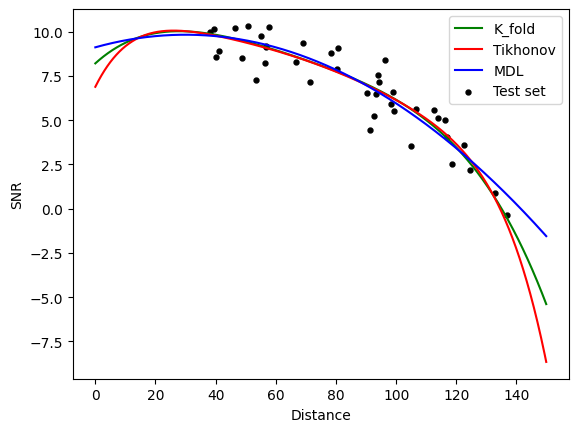

In [41]:
dist_vals = np.arange(0,150,0.1)
pred_SNR_K, pred_SNR_tkh, pred_SNR_MDL  = np.zeros(1500), np.zeros(1500), np.zeros(1500)
for i in range(1500):
    pred_SNR_K[i] = predict(dist_vals[i], best_model_K)
    pred_SNR_tkh[i] = predict(dist_vals[i], best_model_tkh)
    pred_SNR_MDL[i] = predict(dist_vals[i], best_model_MDL)

print("Results of the trained model on the test set")
print("K-Fold Cross Validation: \n", best_model_K, evaluate(x_test, y_test, best_model_K), "\n")
print("Tikhonov Regularization: \n", best_model_tkh, evaluate(x_test, y_test, best_model_tkh), "\n")
print("Minumun Description Lenght: \n", best_model_MDL, evaluate(x_test, y_test, best_model_MDL), "\n")

plt.plot(dist_vals, pred_SNR_K, color='g', label='K_fold')
plt.plot(dist_vals, pred_SNR_tkh, color='r', label='Tikhonov')
plt.plot(dist_vals, pred_SNR_MDL, color='b', label='MDL')
plt.scatter(x_test, y_test, color='k', s = 50, marker='.', label='Test set')
plt.xlabel('Distance')
plt.ylabel('SNR')
plt.legend()
plt.show()